In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/toxic-data/kaggle_data/train_y.csv
/kaggle/input/toxic-data/kaggle_data/train_x.csv
/kaggle/input/toxic-data/kaggle_data/test_x.csv
/kaggle/input/toxic-data/kaggle_data/val_x.csv
/kaggle/input/toxic-data/kaggle_data/val_y.csv


In [2]:
data_dir = '/kaggle/input/toxic-data/kaggle_data/'

In [3]:
import pandas as pd
df_x = pd.read_csv(data_dir + 'train_x.csv')
df_x_= pd.read_csv(data_dir + 'val_x.csv')
df_x = pd.concat([df_x, df_x_], axis=0, ignore_index=True)
df_y = pd.read_csv(data_dir + 'train_y.csv')
df_y_= pd.read_csv(data_dir + 'val_y.csv')
df_y = pd.concat([df_y, df_y_], axis=0, ignore_index=True)


In [4]:
df_x

,index,string
0,0,even up here.......BLACKS!
1,1,Blame men. There's always an excuse to blame ...
2,2,You have no business making any comments on th...
3,3,"""Let's get the black folks and the white folks..."
4,4,I guess the issue is people not willing to put...
...,...,...
314213,45175,"Yes, lynching means hanging - violent death. ..."
314214,45176,"Oh my G-d, a group of men in their 60's and 70..."
314215,45177,"""Donald Trump’s refugee crisis?""\n\nDon't blam..."
314216,45178,Under JPII we moved away from all that love st...


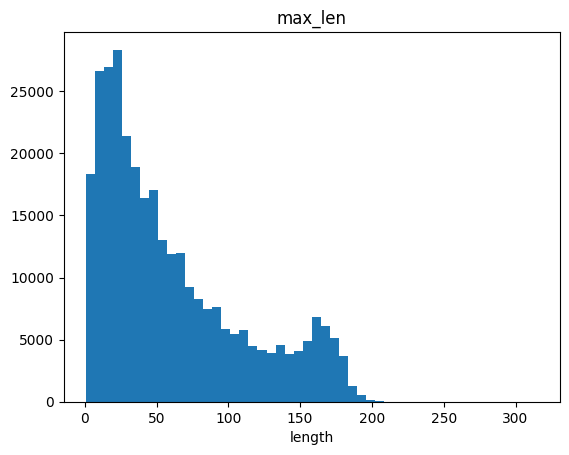

In [5]:
import matplotlib.pyplot as plt

# count for text len distrubution for better max_len choice
df_x['string'] = df_x['string'].astype(str).fillna('')
length = df_x['string'].apply(lambda x: len(x.split()))


plt.hist(length, bins=50)
plt.xlabel('length')
plt.ylabel('')
plt.title('max_len')
plt.show()

In [ ]:

# !pip install transformers datasets evaluate

import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, ClassLabel
from transformers import (
    AutoTokenizer,
    AutoConfig,
    BertPreTrainedModel,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    get_linear_schedule_with_warmup
)
import torch
import torch.nn as nn
import numpy as np
import logging
from evaluate import load
from torch.utils.data import DataLoader 
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts 
# FGM：adversarial training involves attacking the input embeddings
class FGM():
    
    def __init__(self, model):
        self.model = model
        self.backup = {}

    def attack(self, epsilon=1., emb_name='bert.embeddings.word_embeddings'):
        '''
        emb_name:specific embedding layer name
        '''
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                self.backup[name] = param.data.clone()
                norm = torch.norm(param.grad)
                if norm != 0 and not torch.isnan(norm):
                    r_at = epsilon * param.grad / norm
                    param.data.add_(r_at)

    def restore(self, emb_name='bert.embeddings.word_embeddings'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# #  for Colab running
# from google.colab import drive
# drive.mount('/content/drive')

# # for Kaggle running
# data_dir = '/content/drive/MyDrive/Colab_Notebooks/deep/toxic/scr/kaggle_data/'
  


df = pd.merge(df_x, df_y, left_index=True, right_index=True)


df = df.dropna(subset=['string'])
print(f"total row: {len(df)}")

# first run with train & val
# train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

train_df = df.copy() 
# could check label distrubution
print("train label distrubution:")

print(train_df['y'].value_counts())
# print("val label distrubution:")
# print(val_df['y'].value_counts())



model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


# train_dataset = Dataset.from_pandas(train_df)
# val_dataset = Dataset.from_pandas(val_df)
train_dataset = Dataset.from_pandas(train_df)

def tokenize_function(example):
    return tokenizer(
        example["string"],
        truncation=True,
        padding="max_length",
        max_length=150
    )



train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['string', 'index'])
# val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=['string', 'index'])

train_dataset = train_dataset.rename_column("y", "labels")
# val_dataset = val_dataset.rename_column("y", "labels")

print(f"train set label missing: {train_dataset.filter(lambda x: x['labels'] is None).num_rows}")
# print(f"val set label missing: {val_dataset.filter(lambda x: x['labels'] is None).num_rows}")


train_dataset = train_dataset.filter(lambda x: len(x['input_ids']) > 0 and len(x['attention_mask']) > 0)
# val_dataset = val_dataset.filter(lambda x: len(x['input_ids']) > 0 and len(x['attention_mask']) > 0)

num_labels = 2


train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
# val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"] )


print(train_dataset[0])


config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task="sequence_classification"
)

# Check and use multiple GPUs if available
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# for double T4 GPU
if num_gpus > 1:
    print(f"Using {num_gpus} GPUs for training.")
    model = nn.DataParallel(model)


model = BertForSequenceClassification.from_pretrained(
    model_name,
    config=config
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)


epochs = 3
batch_size = 32
epsilon = 1.0  # Adversarial Disturbance


train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)

#  FGM
fgm = FGM(model)


criterion = nn.CrossEntropyLoss()

num_training_steps = len(train_loader) * epochs
# num_warmup_steps = int(0.1 * num_training_steps)

# # first test schedule
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=num_warmup_steps,
#     num_training_steps=num_training_steps
# )

# second test schedule
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,          
    T_mult=2,        
    eta_min=1e-6,    # mini learning rate 
)

# train
for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for batch in progress_bar:
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        
        loss.backward()

        # AD
        fgm.attack(epsilon=epsilon)  

        # Forward propagation with perturbed input
        outputs_adv = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss_adv = outputs_adv.loss
            
        # Back propagation with perturbed grad
        loss_adv.backward()

        # restore
        fgm.restore()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix({'loss': loss.item(), 'loss_adv': loss_adv.item()})

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Training Loss: {avg_loss}")

    # 验证
    # model.eval()
    # correct = 0
    # total = 0
    # val_loss = 0
    # with torch.no_grad():
    #     for batch in tqdm(val_loader, desc="Validation"):
    #         input_ids = batch['input_ids'].to(device)
    #         attention_mask = batch['attention_mask'].to(device)
    #         labels = batch['labels'].to(device)

    #         outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    #         loss = outputs.loss
    #         val_loss += loss.item()

    #         logits = outputs.logits
    #         predictions = torch.argmax(logits, dim=-1)
    #         correct += (predictions == labels).sum().item()
    #         total += labels.size(0)

    # avg_val_loss = val_loss / len(val_loader)
    # accuracy = correct / total
    # print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss}, Accuracy: {accuracy}")
    model_save_path = '/kaggle/working/' + 'trained_model_2_{}'.format(epoch)
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f"model save to {model_save_path}")


total row: 314218
train label distrubution:
y
0    278648
1     35570
Name: count, dtype: int64


Map:   0%|          | 0/314218 [00:00<?, ? examples/s]

Filter:   0%|          | 0/314218 [00:00<?, ? examples/s]

train set label missing: 0


Filter:   0%|          | 0/314218 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'labels': tensor(1), 'input_ids': tensor([  101,  2130,  2039,  2182,  1012,  1012,  1012,  1012,  1012,  1012,
         1012, 10823,   999,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

Epoch 1/3: 100%|██████████| 9820/9820 [2:31:06<00:00,  1.08it/s, loss=0.191, loss_adv=0.266]    


Epoch 1 Training Loss: 0.20355768755700462
model save to /kaggle/working/trained_model_2_0


Epoch 2/3:  56%|█████▌    | 5497/9820 [1:24:35<1:06:16,  1.09it/s, loss=0.0375, loss_adv=0.0397]

In [ ]:
df_test = pd.read_csv(data_dir + 'test_x.csv')  


test_inputs = df_test.loc[:, 'string'].fillna('').tolist()


inputs = tokenizer(
    test_inputs,
    return_tensors="pt",
    truncation=True,
    max_length=128,
    padding=True
).to(device)


predict_batch_size = 32
predictions = []
model.eval()

for i in range(0, len(test_inputs), predict_batch_size):
    batch_inputs = {key: value[i:i+predict_batch_size].to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**batch_inputs)
        logits = outputs.logits
        batch_preds = torch.argmax(logits, dim=-1).cpu().tolist()
        predictions.extend(batch_preds)

print('finish testing', len(predictions), 'sample to test')

pred_df = pd.DataFrame({
    'ID': range(len(predictions)),
    'pred': predictions
})

output_csv_path = '/kaggle/working/' + 'prediction_2.csv' 
pred_df.to_csv(output_csv_path, index=False)
print(f'save to {output_csv_path}')

In [9]:

model_save_path = '/kaggle/working/' + 'trained_model_2'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"model save to {model_save_path}")

model save to /kaggle/working/trained_model
